In [3]:
!pip install split-folders

In [4]:
import os 
import logging
import optuna

import tensorflow
import matplotlib.pyplot as plt 

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


2025-06-26 16:00:12.930856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750953613.164109      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750953613.239192      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
import splitfolders

splitfolders.ratio("/kaggle/input/datasettt/data", output="/kaggle/working/main",seed=1337, ratio=(.7, .2, .1))

Copying files: 5194 files [00:25, 205.84 files/s]


In [6]:
# creating a pipeline to generate the data : data generator

train = keras.utils.image_dataset_from_directory(
    "/kaggle/working/main/train",
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    verbose=True,
)
val = keras.utils.image_dataset_from_directory(
    "/kaggle/working/main/val",
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    verbose=True,
)
test = keras.utils.image_dataset_from_directory(
    "/kaggle/working/main/test",
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    verbose=True,
)

Found 3635 files belonging to 5 classes.


I0000 00:00:1750953664.669677      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 1038 files belonging to 5 classes.
Found 521 files belonging to 5 classes.


In [7]:
optuna.logging.get_logger('optuna').addHandler(logging.StreamHandler())

In [8]:
train = train.map(lambda x, y: (x / 255.0, y)).cache().shuffle(1000).prefetch(tensorflow.data.AUTOTUNE)
val = val.map(lambda x, y: (x / 255.0, y)).cache().prefetch(tensorflow.data.AUTOTUNE)

In [9]:

def objective(trial):
    
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "parametric relu"])
    n_layers = trial.suggest_int("n_layers", 1, 3)
    n_units = trial.suggest_categorical("n_units", [64, 128, 256, 512])
    optimizer = trial.suggest_categorical("optimizer", ["adam", "sgd", "adagrad"])

    base_model = keras.applications.MobileNet(
        include_top=False, weights='imagenet', input_shape=(224, 224, 3)
    )
    base_model.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())

    for i in range(n_layers):
        model.add(layers.Dense(n_units))
        if activation == "parametric relu":
            model.add(layers.PReLU())
        else:
            model.add(layers.Activation(activation))
        model.add(layers.Dropout(0.5))

    model.add(layers.Dense(17, activation="softmax"))

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    checkpoint_path = f"mobilenet_checkpoints/mobilenet_trial_{trial.number}.keras"
    os.makedirs("mobilenet_checkpoints", exist_ok=True)

    callbacks = [
        ModelCheckpoint(
            filepath=checkpoint_path,
            monitor="val_loss",
            save_best_only=True,
            save_weights_only=False,
            mode="min",
            verbose=0
        ),
        EarlyStopping(
            monitor="val_loss",
            patience=10,
            restore_best_weights=True,
            verbose=0
        )
    ]

    history = model.fit(
        train,
        validation_data=val,
        epochs=50,
        batch_size=256,
        callbacks=callbacks,
        verbose=1
    )

    val_loss = history.history["val_loss"][-1]
    trial.set_user_attr("val_accuracy", history.history.get("val_accuracy", [None])[-1])
    trial.set_user_attr("history", history.history)
    
    return val_loss


In [10]:


# Logging and study setup
optuna.logging.get_logger("optuna").addHandler(logging.FileHandler("optuna_mobilenet_1.log"))

study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.RandomSampler(),
    study_name="mobilenet_tuning"
)

study.optimize(objective, n_trials=5,show_progress_bar=True)



[I 2025-06-26 16:14:38,805] A new study created in memory with name: mobilenet_tuning
A new study created in memory with name: mobilenet_tuning


  0%|          | 0/5 [00:00<?, ?it/s]

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


I0000 00:00:1750954488.697682     109 service.cc:148] XLA service 0x7b62841281b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750954488.698388     109 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750954489.292252     109 cuda_dnn.cc:529] Loaded cuDNN version 90300


 10/114 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.1700 - loss: 3.1194

I0000 00:00:1750954492.668689     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


114/114 ━━━━━━━━━━━━━━━━━━━━ 22s 84ms/step - accuracy: 0.3437 - loss: 2.0314 - val_accuracy: 0.9335 - val_loss: 0.6270
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7366 - loss: 0.7857 - val_accuracy: 0.9711 - val_loss: 0.3761
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8355 - loss: 0.5304 - val_accuracy: 0.9827 - val_loss: 0.2709
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9005 - loss: 0.3891 - val_accuracy: 0.9904 - val_loss: 0.2108
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9245 - loss: 0.3080 - val_accuracy: 0.9933 - val_loss: 0.1738
Epoch 6/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9377 - loss: 0.2602 - val_accuracy: 0.9952 - val_loss: 0.1468
Epoch 7/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9531 - loss: 0.2391 - val_accuracy: 0.9961 - val_loss: 0.1276
Epoch 8/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9540 - loss: 0.2080 - val_accuracy: 0.99

Trial 0 finished with value: 0.015861790627241135 and parameters: {'activation': 'parametric relu', 'n_layers': 1, 'n_units': 256, 'optimizer': 'adagrad'}. Best is trial 0 with value: 0.015861790627241135.


[I 2025-06-26 16:17:20,115] Trial 0 finished with value: 0.015861790627241135 and parameters: {'activation': 'parametric relu', 'n_layers': 1, 'n_units': 256, 'optimizer': 'adagrad'}. Best is trial 0 with value: 0.015861790627241135.
Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - accuracy: 0.1519 - loss: 2.9752 - val_accuracy: 0.3536 - val_loss: 2.0953
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.2634 - loss: 2.3099 - val_accuracy: 0.4316 - val_loss: 1.7698
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.3302 - loss: 2.0130 - val_accuracy: 0.5732 - val_loss: 1.5069
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.3761 - loss: 1.8319 - val_accuracy: 0.6975 - val_loss: 1.2999
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.3993 - loss: 1.6988 - val_accuracy: 0.8015 - val_loss: 1.1282
Epoch 6/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.4642 - loss: 1.5358 - val_accuracy: 0.8613 - val_loss

Trial 1 finished with value: 0.08690252900123596 and parameters: {'activation': 'parametric relu', 'n_layers': 2, 'n_units': 64, 'optimizer': 'adagrad'}. Best is trial 0 with value: 0.015861790627241135.


[I 2025-06-26 16:19:59,955] Trial 1 finished with value: 0.08690252900123596 and parameters: {'activation': 'parametric relu', 'n_layers': 2, 'n_units': 64, 'optimizer': 'adagrad'}. Best is trial 0 with value: 0.015861790627241135.
Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - accuracy: 0.2067 - loss: 2.5156 - val_accuracy: 0.8092 - val_loss: 1.1994
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.4388 - loss: 1.4535 - val_accuracy: 0.9200 - val_loss: 0.7957
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5841 - loss: 1.1069 - val_accuracy: 0.9441 - val_loss: 0.5394
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6919 - loss: 0.8589 - val_accuracy: 0.9653 - val_loss: 0.3928
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7393 - loss: 0.7027 - val_accuracy: 0.9730 - val_loss: 0.2954
Epoch 6/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7787 - loss: 0.5859 - val_accuracy: 0.9730 - val_loss: 

Trial 2 finished with value: 0.002911563264206052 and parameters: {'activation': 'relu', 'n_layers': 3, 'n_units': 512, 'optimizer': 'adagrad'}. Best is trial 2 with value: 0.002911563264206052.


[I 2025-06-26 16:22:39,805] Trial 2 finished with value: 0.002911563264206052 and parameters: {'activation': 'relu', 'n_layers': 3, 'n_units': 512, 'optimizer': 'adagrad'}. Best is trial 2 with value: 0.002911563264206052.
Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.2613 - loss: 2.2157 - val_accuracy: 0.7775 - val_loss: 0.9935
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6436 - loss: 1.1106 - val_accuracy: 0.8796 - val_loss: 0.6844
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7546 - loss: 0.8458 - val_accuracy: 0.9200 - val_loss: 0.5313
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8059 - loss: 0.7079 - val_accuracy: 0.9470 - val_loss: 0.4331
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8680 - loss: 0.5443 - val_accuracy: 0.9644 - val_loss: 0.3683
Epoch 6/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8844 - loss: 0.4864 - val_accuracy: 0.9827 - val_loss: 0.3167
Ep

Trial 3 finished with value: 0.04252347722649574 and parameters: {'activation': 'tanh', 'n_layers': 1, 'n_units': 64, 'optimizer': 'adagrad'}. Best is trial 2 with value: 0.002911563264206052.


[I 2025-06-26 16:25:10,317] Trial 3 finished with value: 0.04252347722649574 and parameters: {'activation': 'tanh', 'n_layers': 1, 'n_units': 64, 'optimizer': 'adagrad'}. Best is trial 2 with value: 0.002911563264206052.
Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 16s 78ms/step - accuracy: 0.1161 - loss: 3.0666 - val_accuracy: 0.3593 - val_loss: 1.9983
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.2286 - loss: 2.2227 - val_accuracy: 0.6763 - val_loss: 1.6391
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.2910 - loss: 1.9711 - val_accuracy: 0.7187 - val_loss: 1.3959
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.3557 - loss: 1.7455 - val_accuracy: 0.7601 - val_loss: 1.1762
Epoch 5/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.4032 - loss: 1.5839 - val_accuracy: 0.8150 - val_loss: 1.0223
Epoch 6/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.4579 - loss: 1.4234 - val_accuracy: 0.8324 - val_loss: 0.8880
Epoc

Trial 4 finished with value: 0.04615683853626251 and parameters: {'activation': 'relu', 'n_layers': 3, 'n_units': 128, 'optimizer': 'adagrad'}. Best is trial 2 with value: 0.002911563264206052.


[I 2025-06-26 16:27:47,827] Trial 4 finished with value: 0.04615683853626251 and parameters: {'activation': 'relu', 'n_layers': 3, 'n_units': 128, 'optimizer': 'adagrad'}. Best is trial 2 with value: 0.002911563264206052.


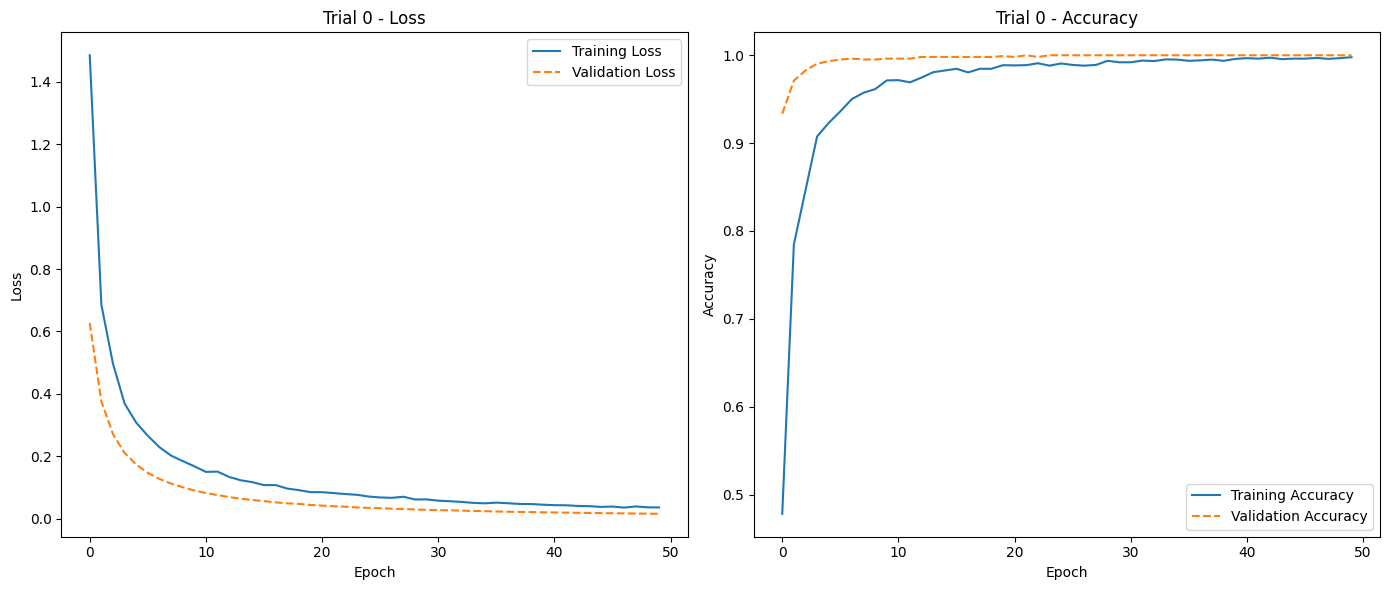

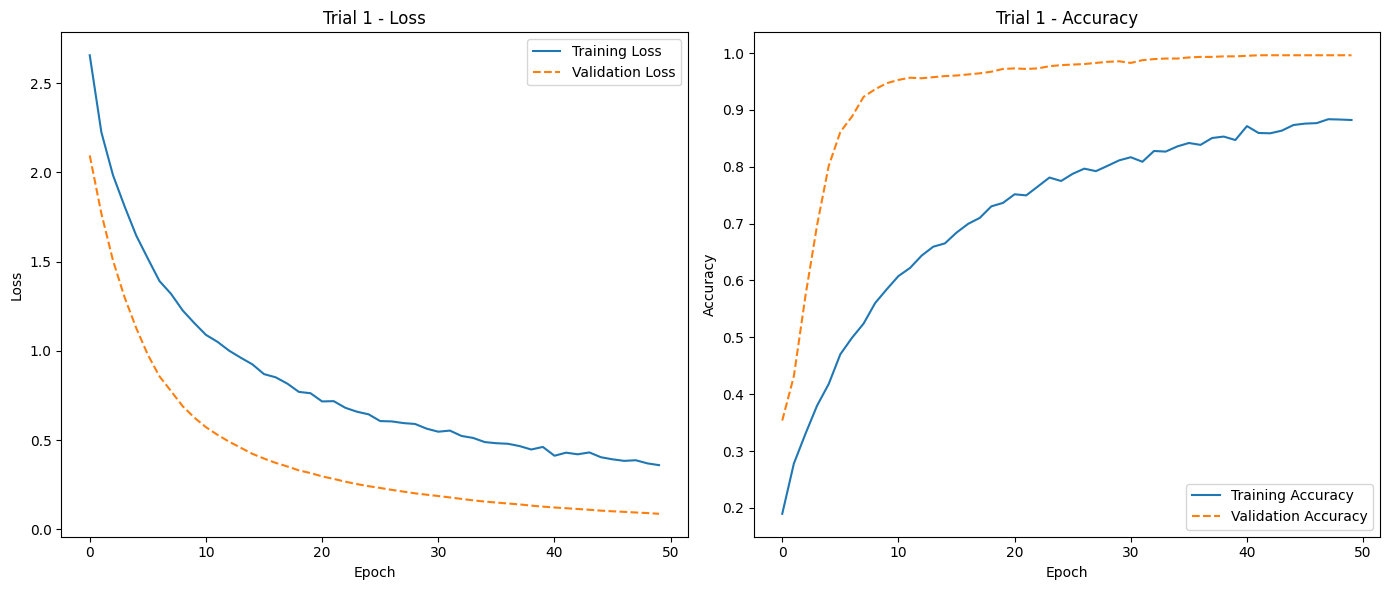

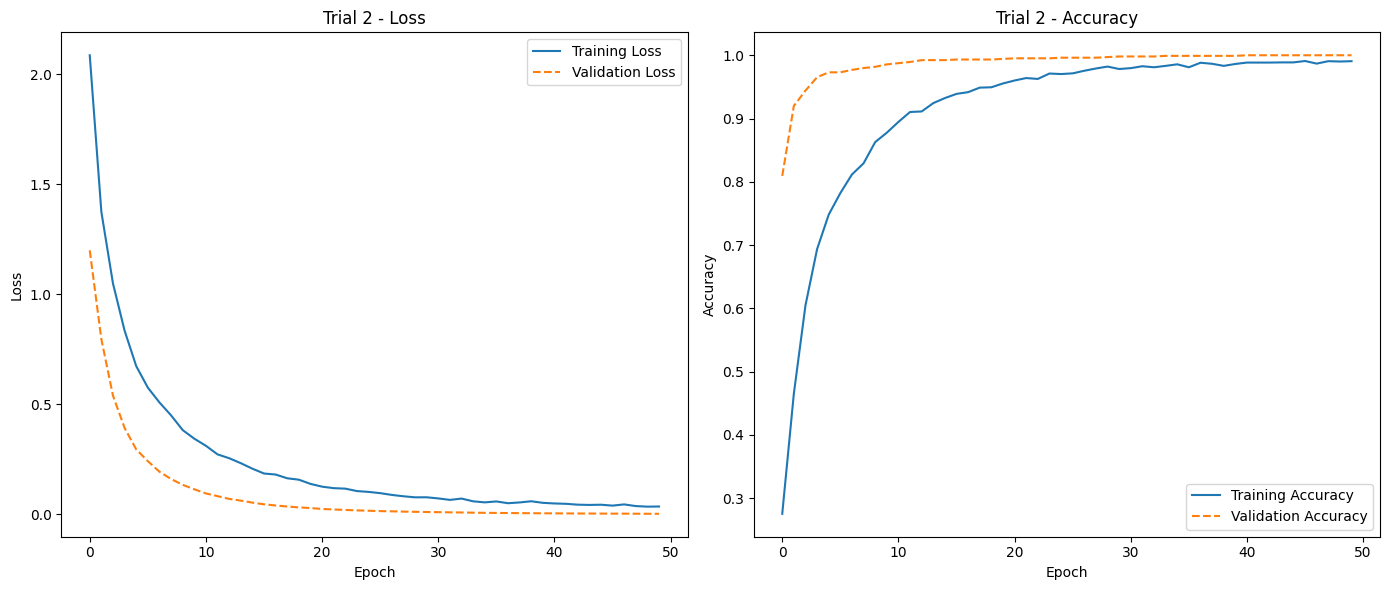

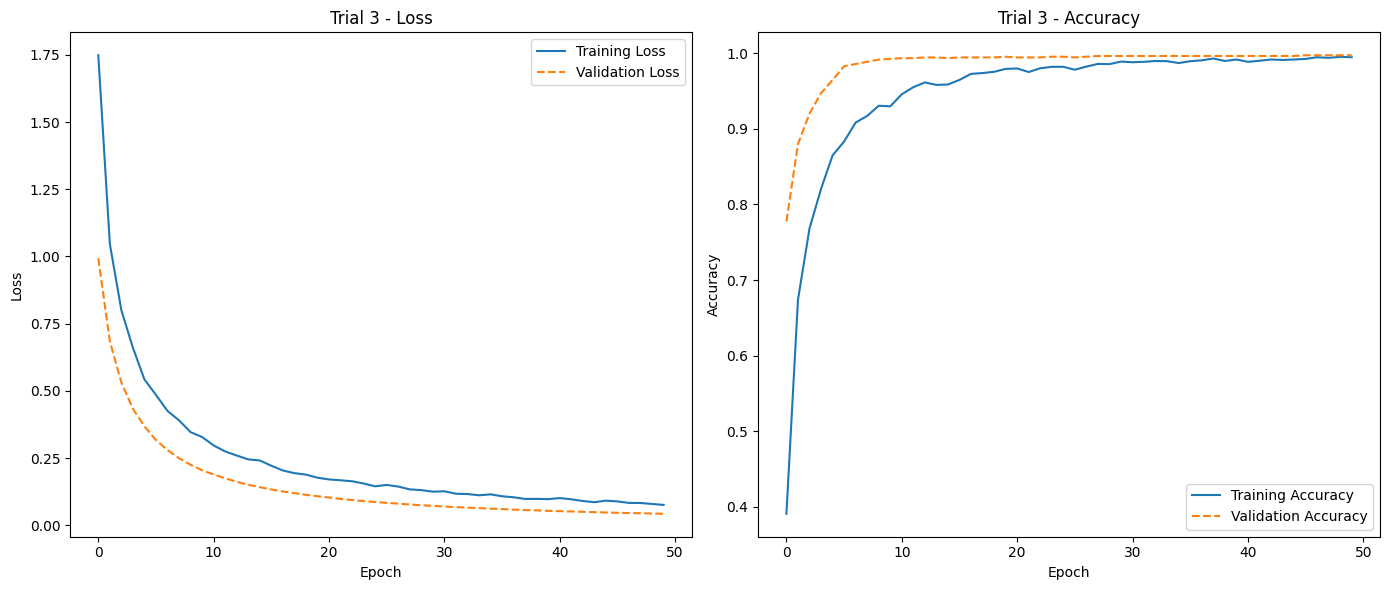

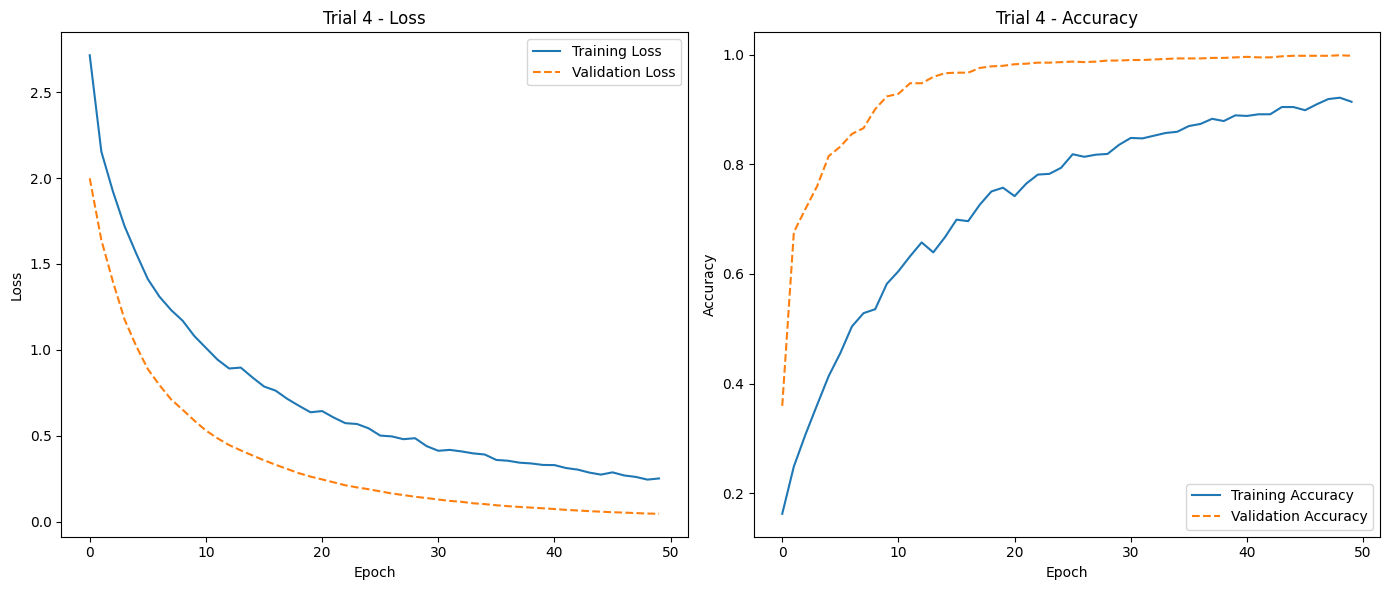

In [11]:
import matplotlib.pyplot as plt
import os

os.makedirs("mobilenet_optuna_plots", exist_ok=True)

for trial in study.trials:
    history = trial.user_attrs.get("history")
    if history:
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))
        
        # Plot Loss
        axs[0].plot(history["loss"], label="Training Loss")
        axs[0].plot(history["val_loss"], linestyle='--', label="Validation Loss")
        axs[0].set_title(f"Trial {trial.number} - Loss")
        axs[0].set_xlabel("Epoch")
        axs[0].set_ylabel("Loss")
        axs[0].legend()

        # Plot Accuracy
        axs[1].plot(history["accuracy"], label="Training Accuracy")
        axs[1].plot(history["val_accuracy"], linestyle='--', label="Validation Accuracy")
        axs[1].set_title(f"Trial {trial.number} - Accuracy")
        axs[1].set_xlabel("Epoch")
        axs[1].set_ylabel("Accuracy")
        axs[1].legend()

        plt.tight_layout()
        plt.savefig(f"mobilenet_optuna_plots/mobilenet_trial_{trial.number}_plot.png")
        plt.show()

In [12]:
import shutil
shutil.make_archive('mobilenet_optuna_checkpoints', 'zip', "/kaggle/working/mobilenet_checkpoints")

'/kaggle/working/mobilenet_optuna_checkpoints.zip'

In [13]:
shutil.make_archive('mobilenet_optuna_plots', 'zip', "/kaggle/working/mobilenet_optuna_plots")

'/kaggle/working/mobilenet_optuna_plots.zip'